<a href="https://colab.research.google.com/github/WyvernCore/Deep-RL/blob/main/Soft_Actor_Critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Soft Actor-Critic (SAC)

In [1]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    xvfb \
    libosmesa6-dev \
    software-properties-common \
    patchelf

!pip install \
    free-mujoco-py \
    gym==0.21 \
    gym[box2d] \
    pytorch-lightning==1.6.0 \
    optuna \
    pyvirtualdisplay \
    PyOpenGL \
    PyOpenGL-accelerate

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
libgl1-mesa-dev set to manually installed.
software-properties-common is already the newest version (0.96.24.32.18).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  glew-utils
The following NEW packages will be installed:
  libgl1-mesa-glx libglew-dev libglew2.0 libosmesa6 libosmesa6-dev patchelf
  xvfb
0 upgraded, 7 newly installed, 0 to remove and 49 not upgraded.
Need to get 3,747 kB of archives.
After this operation, 15.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgl1-mesa-glx amd64 20.0.8-0ubuntu1~18.04.1 [5,532 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libglew2.0 amd64 2.0.0-5 [140 kB]
Get:3 http://archive.ubuntu.com/ub

#### Setup virtual display

In [2]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

#### Import the necessary code libraries

In [3]:
import copy
import gym
import torch
import itertools
import random

import numpy as np
import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW
from torch.distributions.normal import Normal

from pytorch_lightning import LightningModule, Trainer

from gym.wrappers import RecordVideo, RecordEpisodeStatistics, \
  FilterObservation, FlattenObservation


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

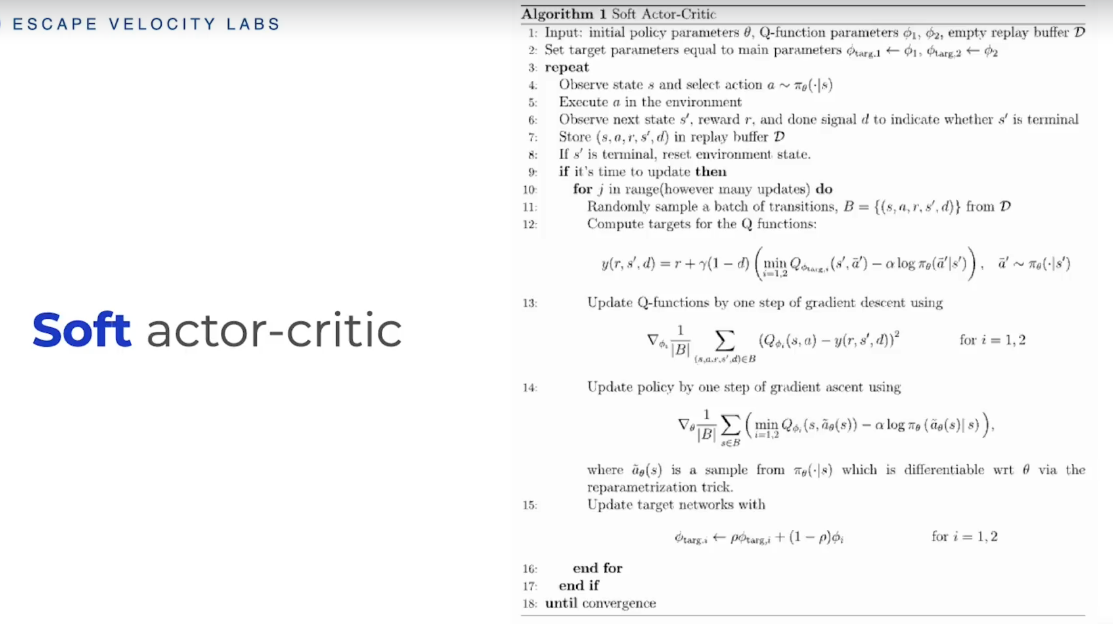

In [4]:
def display_video(episode=0):
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

#### Create the replay buffer

In [5]:
class ReplayBuffer: #Store enviroment observations (kinda like a database) | Stored as [State, Action, Reward, Next State] 
  def __init__(self, capacity): #defining the capacity of the replay buffer
    self.buffer = deque(maxlen=capacity) #Using a queue data structure

  def __len__(self):  #return the length of the buffer
    return len(self.buffer)
  
  def append(self, experience): #save experience in the database
    self.buffer.append(experience)
  
  def sample(self, batch_size):
    return random.sample(self.buffer, batch_size) #get a sample of explisit buffer size

In [6]:
class RLDataset(IterableDataset): #class to allow pytorch to select a sample from buffer one at a time (the batch)
  def __init__(self, buffer, sample_size=400): #go through each element one at a time
    self.buffer = buffer
    self.sample_size = sample_size
  
  def __iter__(self): #take a sample from buffer and return elements one at a time
    for exp in self.buffer.sample(self.sample_size):
      yield exp

#### Create the environment

In [7]:
env = gym.make('FetchReachDense-v1')

Compiling /usr/local/lib/python3.7/dist-packages/mujoco_py/cymj.pyx because it changed.
[1/1] Cythonizing /usr/local/lib/python3.7/dist-packages/mujoco_py/cymj.pyx
running build_ext
building 'mujoco_py.cymj' extension
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7/usr
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7/usr/local
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7/usr/local/lib
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuexten

In [8]:
env.reset() #goal enviroment -> the desired goal is included in the enviroment | make achieved goal equal desired goal

#sparse rewards 

{'achieved_goal': array([1.34183265, 0.74910039, 0.53472272]),
 'desired_goal': array([1.35020818, 0.62481843, 0.44377199]),
 'observation': array([ 1.34183265e+00,  7.49100387e-01,  5.34722720e-01,  1.97805133e-04,
         7.15193042e-05,  7.73933014e-06,  5.51992816e-08, -2.42927453e-06,
         4.73325650e-06, -2.28455228e-06])}

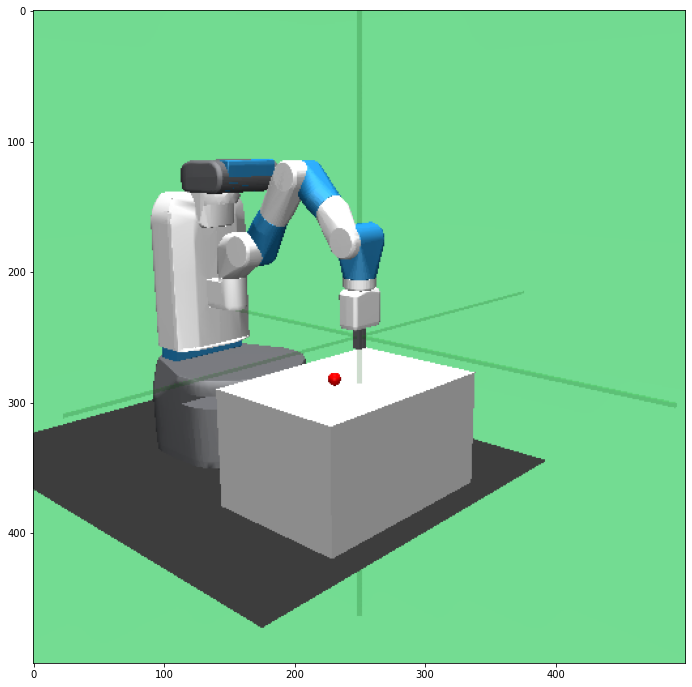

In [12]:
import matplotlib.pyplot as plt
frame = env.render(mode='rgb_array')
plt.figure(figsize=(12,12))
plt.imshow(frame)

In [14]:
env.action_space #applying torc and between first two arrays and force on gripper (constant)

Box([-1. -1. -1. -1.], [1. 1. 1. 1.], (4,), float32)

In [18]:
def create_environment(name):
  env = gym.make(name)
  env = FilterObservation(env, ['observation', 'desired_goal']) #filter out achieved goal
  env = FlattenObservation(env) #combine together in an array
  env = RecordVideo(env, video_folder='./videos', episode_trigger=lambda x: x%50 == 0) #record every fifty episodes
  env = RecordEpisodeStatistics(env) #Keep history of rewards from the env
  return env

In [19]:
env = create_environment('FetchReachDense-v1')
env.reset()

array([ 1.2172353e+00,  6.6717052e-01,  5.5913502e-01,  1.3418326e+00,
        7.4910039e-01,  5.3472275e-01,  1.9780513e-04,  7.1519302e-05,
        7.7393297e-06,  5.5199283e-08, -2.4292744e-06,  4.7332564e-06,
       -2.2845522e-06], dtype=float32)

#### Update the target network

In [20]:
def polyak_average(net, target_net, tau=0.01):
  for qp, tp in zip(net.parameters(), target_net.parameters()): #qp -> Q Param, tp -> target Param
    tp.data.copy_(tau * qp.data + (1 - tau) * tp.data) #formule of polyak averaging using actual and target network as well as tau @

#### Create the Deep Q-Network

In [23]:
class DQN(nn.Module):

  def __init__(self, hidden_size, obs_size, out_dims): 
    super().__init__()
    self.net = nn.Sequential( #take as input action and observation size
      nn.Linear(obs_size + out_dims, hidden_size), #Input Layer
      nn.ReLU(), #ReLu activation function
      nn.Linear(hidden_size, hidden_size), #hidden Layer
      nn.ReLU(), #ReLu activation function
     nn.Linear(hidden_size, 1) #output a single value
    )

  def forward(self, state, action):
    if isinstance(state, np.ndarray): #turn into pytorch tensors
      state = torch.from_numpy(state).to(device)
    if isinstance(action, np.ndarray): #turn into pytorch tensors
      action = torch.from_numpy(action).to(device)
    in_vector = torch.hstack((state, action)) #horizontal stack
    return self.net(in_vector.float())

#### Create the gradient policy

In [24]:
class GradientPolicy(nn.Module):

  def __init__(self, hidden_size, obs_size, out_dims, max):
    super().__init__()
    #self.min = torch.from_numpy(min).to(device)
    self.max = torch.from_numpy(max).to(device)

    self.net = nn.Sequential(
        nn.Linear(obs_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),

    )

    self.linear_mu = nn.Linear(hidden_size, out_dims)
    self.linear_std = nn.Linear(hidden_size, out_dims)


  def forward(self, obs): #select actions following a standard diviation
    if isinstance(obs, np.ndarray):
      obs = torch.from_numpy(obs).to(device)
    x = self.net(obs.float())
    mu = self.linear_mu(x)
    std = self.linear_std(x) #creating a stochastic policy
    std = F.softplus(std) + 1e-3 #similar to ReLU but instead of clamping values to 0, they are clmaped approaching 0

    dist = Normal(mu, std) #Normal Distribution, sampled between -inf to +inf
    action = dist.rsample()
    log_prob = dist.log_prob(action)
    log_prob = log_prob.sum(dim=-1, keepdim=True)
    log_prob -= (2 * (np.log(2) - action - F.softplus(-2 * action))).sum(dim=-1, keepdim=True) #keep stability with probabilities 

    action = torch.tanh(action) * self.max


    return action
    

#### Soft actor-critic algorithm

In [25]:
class SAC(LightningModule):

  def __init__(self, env_name, capacity=100_000, batch_size=256, lr=1e-3,  
               hidden_size=256, gamma=0.99, loss_fn=F.smooth_l1_loss, optim=AdamW,
               samples_per_epoch=1_000, tau=0.05, epsilon=0.05, alpha=0.02):
    super().__init__()
    #self.env = create_environment(env_name) 
    #self.obs = self.env.reset()
    #self.videos = []

    obs_size = self.env.observation_space.shape[0] 
    action_dims =  self.env.action_space.shape[0]
    max_action = self.env.action_space.high #get the max action

    self.q_net_1 = DQN(hidden_size, obs_size, action_dims) #create the NN
    self.q_net_2 = DQN(hidden_size, obs_size, action_dims) #create the NN
    self.policy = GradientPolicy(hidden_size, obs_size, action_dims, max_action) #create the policy
    
    self.target_policy = copy.deepcopy(self.policy) #create the target policy
    self.target_q_net_1 = copy.deepcopy(self.q_net_1) #create the target NN
    self.target_q_net_2 = copy.deepcopy(self.q_net_2) #create the target NN

    self.buffer = ReplayBuffer(capacity=capacity)

    self.save_hyperparameters()

    while len(self.buffer) < self.hparams.samples_per_epoch: #keep filling buffer
      print(f"{len(self.buffer)} samples in expience buffer. Filling....")
      self.play(epsilon=self.hparams.eps_start)

  @torch.no_grad() #treat actions as constants 
  def play(self, policy=None, epsilon=0.): #play one move
    obs = self.env.reset()
    done = False

    while not done:
      if policy and random.random() > self.hparams.epsilon:
        action, _ = self.policy(obs)
        action = action.cpu().numpy()
      else:
        action = self.env.action_space.sample()

      next_obs, reward, done, info = self.env.step(action) #take an action in the enviroment
      exp = (obs, action, reward, done, next_obs) #store the exp to be stored in the exp replay buffer
      self.buffer.append(exp) #save in the buffer 
      obs = next_obs #set next to curr
    # Foward Pass
  
  def forward(self, x): #take a state input -> produce q value
    output = self.policy(x)
    return output

  def configure_optimizers(self): #updated to support both q-networks
    q_net_params = itertools.chain(self.q_net_1.parameters(), self.q_net_2.parameters())
    q_net_optimizer = self.hparams.optim(q_net_params, lr=self.hparams.critic_lr) # Q-Net <- Critic 
    policy_optimizer = self.hparams.optim(self.policy.parameters(), lr=self.hparams.actor_lr) # Policy <- Actor
    return [q_net_optimizer, policy_optimizer] #might be more than one NN thus rap in list, return actor and critic

  def train_dataloader(self): #spacify how to get training data
    dataset = RLDataset(self.buffer, self.hparams.samples_per_epoch)
    dataloader = DataLoader(
      dataset = dataset,
      batch_size = self.hparams.batch_size
    )
    return dataloader

  def training_step(self, batch, batch_idx, optimizer_idx): #called twice, once with the actor another for critic
    states, actions, rewards, dones, next_states = batch #retrieve data from batch, correct the batch size
    rewards = rewards.unsqueeze(1)
    dones = dones.unsqueeze(1).bool()

    if optimizer_idx == 0: #train Q-Network

      action_values_1 = self.q_net_1(states, actions)
      action_values_2 = self.q_net_2(states, actions)

      next_actions, target_log_probs = self.target_policy(next_states)

      next_action_values = torch.min(self.target_q_net_1(next_states, next_actions), self.target_q_net_2(next_states, next_actions))
      
      next_action_values[dones] = 0.0 #no extra rewards

      target = rewards + self.hparams.gamma * (next_action_values - self.hparams.alpha * target_log_probs) #keep exploration high


      q_loss_1 = self.hparams.loss_fn(action_values_1, target)
      q_loss_2 = self.hparams.loss_fn(action_values_2, target)
      total_loss = q_loss_1 + q_loss_2

      self.log('episode/Q-Error', total_loss) #compute loss, return total q_loss of both networks

      return total_loss
    
    elif optimizer_idx == 1: #train Policy
      actions, target_log_probs = self.policy(states)
      
      

    

SyntaxError: ignored

In [ ]:
# Start tensorboard.
!rm -r /content/lightning_logs/
!rm -r /content/videos/
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/